<a href="https://colab.research.google.com/github/VMBoehm/pydelfi/blob/additons/cosmic_shear_prerun_sims__same_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import stuff

In [1]:
!pip install -q https://github.com/VMBoehm/pydelfi/archive/master.zip

     | 25.1MB 112.1MB/s


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pydelfi.priors as priors
import pydelfi.ndes as ndes
import pydelfi.delfi as delfi
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
%matplotlib inline

## Set up the prior

In [0]:
lower = np.array([0, 0.4, 0, 0.4, 0.7])
upper = np.array([1, 1.2, 0.1, 1.0, 1.3])
prior = priors.Uniform(lower, upper)

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
!ls gdrive/My\ Drive/pydelfi/examples

cosmic_shear.ipynb		jla_sne.ipynb		    simulators
cosmic_shear_prerun_sims.ipynb	jla_sne_marginalized.ipynb


## Load in the compressed data vector, sims, Fisher matrix, fiducial params
`compressed_data` is an array of length `n_summaries`<br>
`sim_params` is an array with shape `(n_simulations, n_parameters)`<br>
`sim_compressed_data` is an array with shape `(n_simulations, n_summaries)`

In [0]:
compressed_data = np.genfromtxt('gdrive/My Drive/pydelfi/examples/simulators/cosmic_shear/pre_ran_sims/compressed_data.dat')

sim_params = np.genfromtxt('gdrive/My Drive/pydelfi/examples/simulators/cosmic_shear/pre_ran_sims/simulations_parameters.dat')

sim_compressed_data = np.genfromtxt('gdrive/My Drive/pydelfi/examples/simulators/cosmic_shear/pre_ran_sims/simulations_compressed_data.dat')

Finv = np.genfromtxt('gdrive/My Drive/pydelfi/examples/simulators/cosmic_shear/pre_ran_sims/Finv.dat')

theta_fiducial = np.array([0.3, 0.8, 0.05, 0.70, 0.96])

## Create ensemble of NDEs

In [7]:
NDEs = [ndes.ConditionalMaskedAutoregressiveFlow(n_parameters=5, n_data=5, n_hiddens=[50,50], n_mades=5, act_fun=tf.tanh, index=0),
        ndes.ConditionalMaskedAutoregressiveFlow(n_parameters=5, n_data=5, n_hiddens=[50,50], n_mades=5, act_fun=tf.tanh, index=1),
        ndes.ConditionalMaskedAutoregressiveFlow(n_parameters=5, n_data=5, n_hiddens=[50,50], n_mades=5, act_fun=tf.tanh, index=2),
        ndes.MixtureDensityNetwork(n_parameters=5, n_data=5, n_components=5, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=3),
        ndes.MixtureDensityNetwork(n_parameters=5, n_data=5, n_components=5, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=4),
        ndes.MixtureDensityNetwork(n_parameters=5, n_data=5, n_components=5, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=5)]
       


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



## Create DELFI object

In [0]:
DelfiEnsemble = delfi.Delfi(compressed_data, prior, NDEs, 
                            Finv = Finv, 
                            theta_fiducial = theta_fiducial, 
                            param_limits = [lower, upper],
                            param_names = ['\Omega_m', 'S_8', '\Omega_b', 'h', 'n_s'], 
                            results_dir = "gdrive/My Drive/pydelfi/examples/simulators/cosmic_shear/results_stab/",
                            input_normalization="fisher")

## Load simulations into DELFI object

In [0]:
DelfiEnsemble.load_simulations(sim_compressed_data, sim_params)

## Fisher pre-training to initialize networks

Sampling approximate posterior...
Done.
Removed no burn in


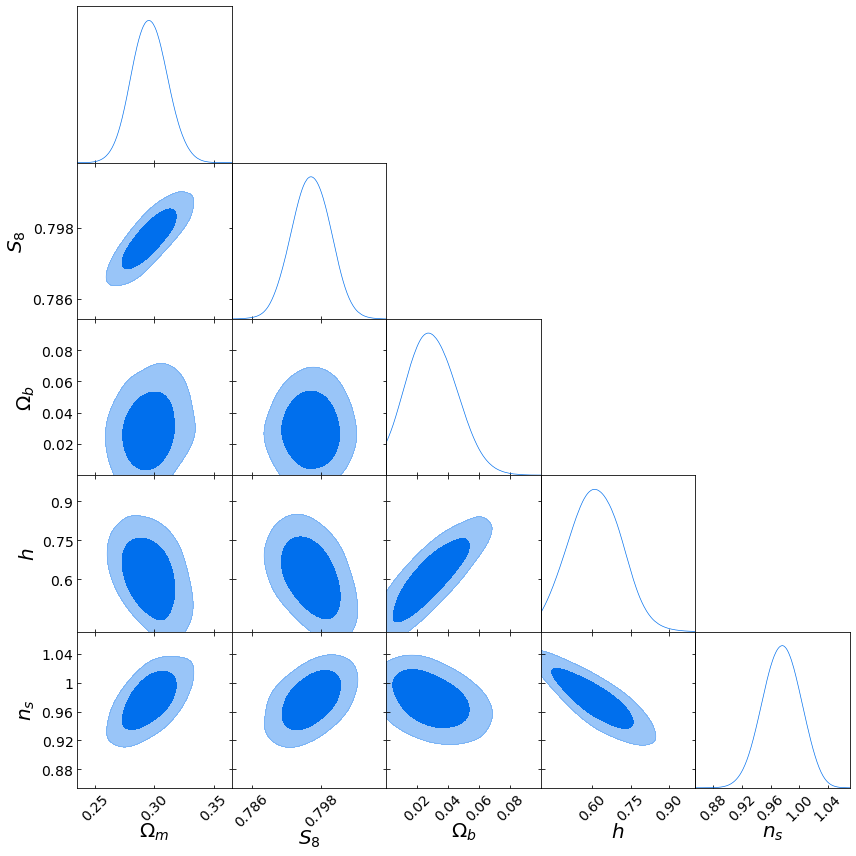

In [10]:
DelfiEnsemble.fisher_pretraining(n_batch=5000, batch_size=100)

# Train the networks

In [11]:
DelfiEnsemble.train_ndes()

# Sample the learned posterior

In [0]:
posterior_samples = DelfiEnsemble.emcee_sample()

# Alright let's plot it!
Feed it a list of `(n_samples, n_parameters)` arrays for making a triangle plot; in this case let's just plot the posterior samples.

Removed no burn in


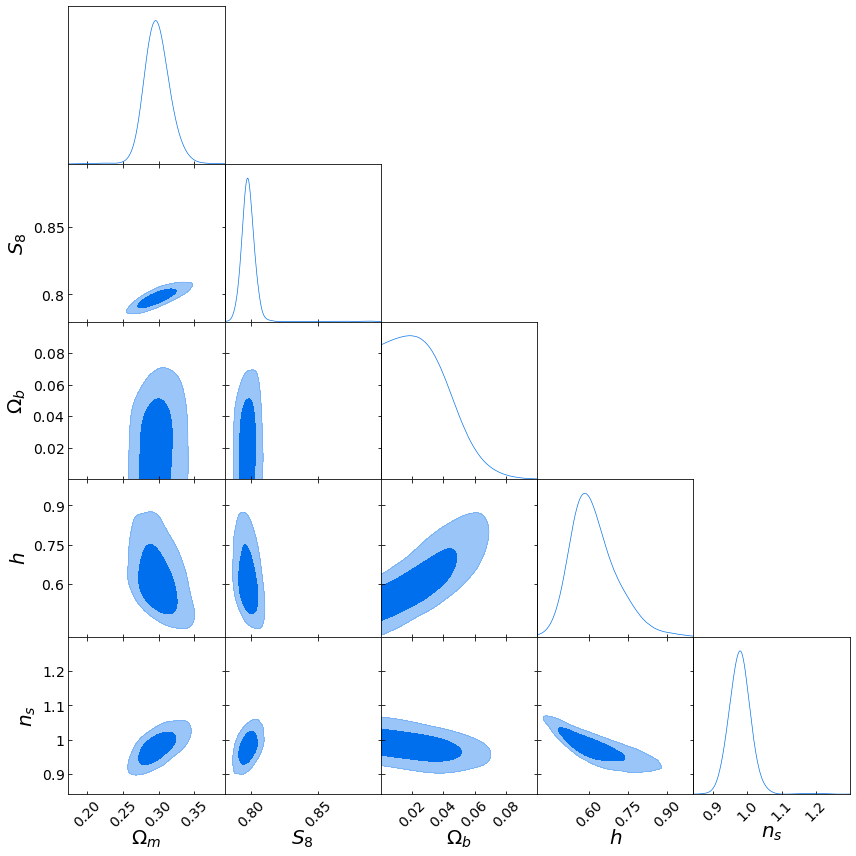

In [13]:
DelfiEnsemble.triangle_plot(samples=[posterior_samples])

In [0]:
samples = []
for i in range(6):
    samples.append(DelfiEnsemble.emcee_sample(log_likelihood=lambda x: DelfiEnsemble.log_posterior_individual(i, x)))

Removed no burn in


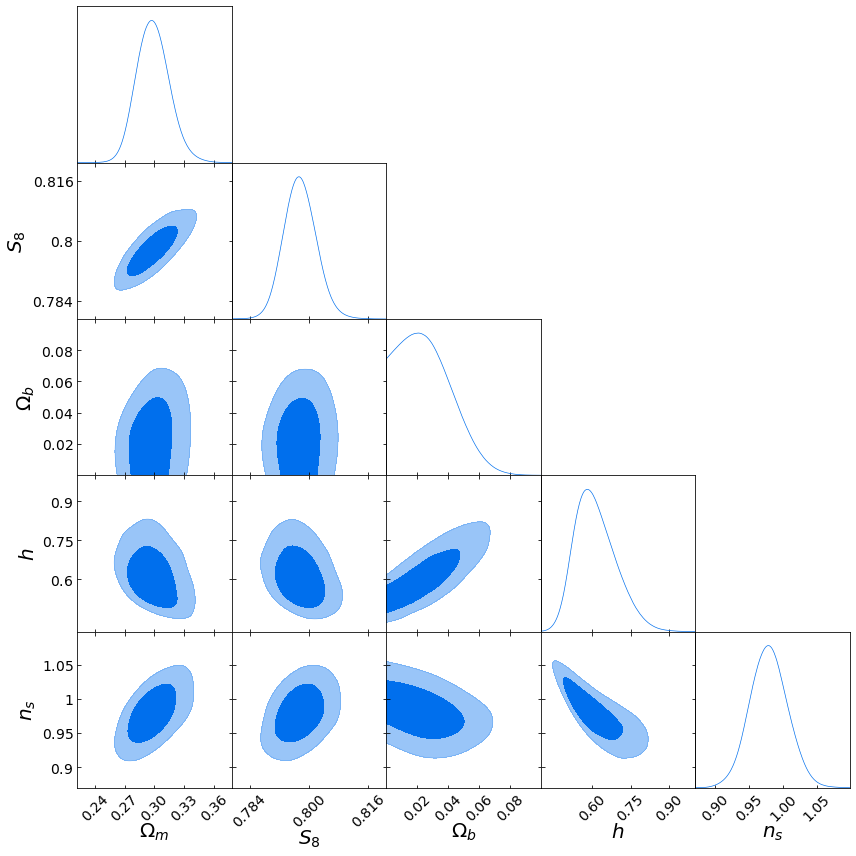

Removed no burn in


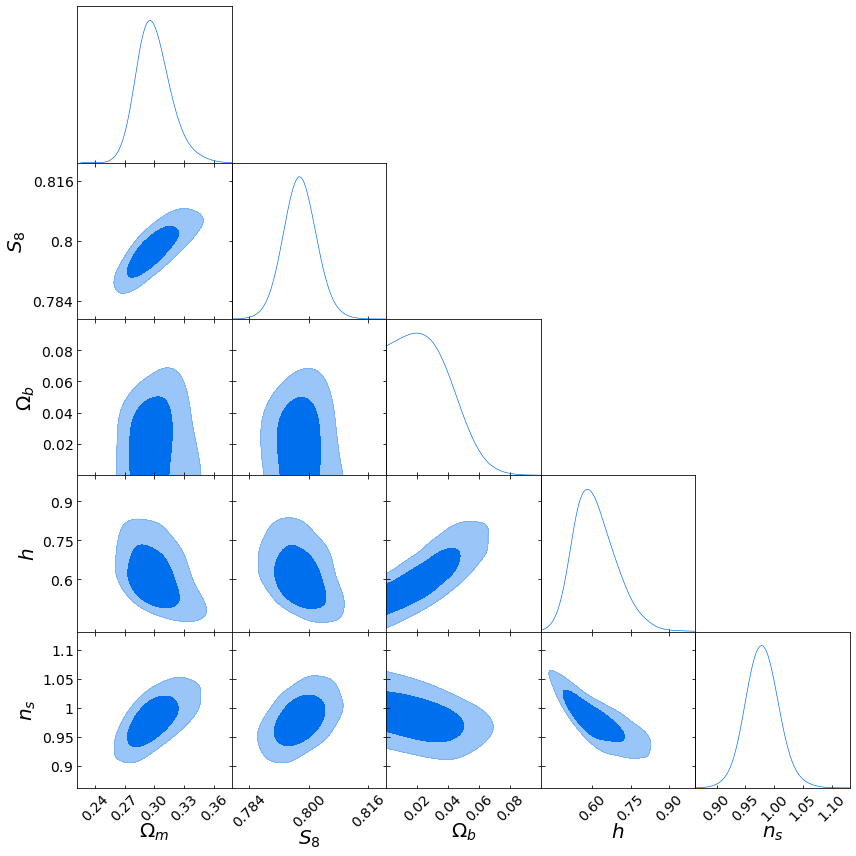

Removed no burn in


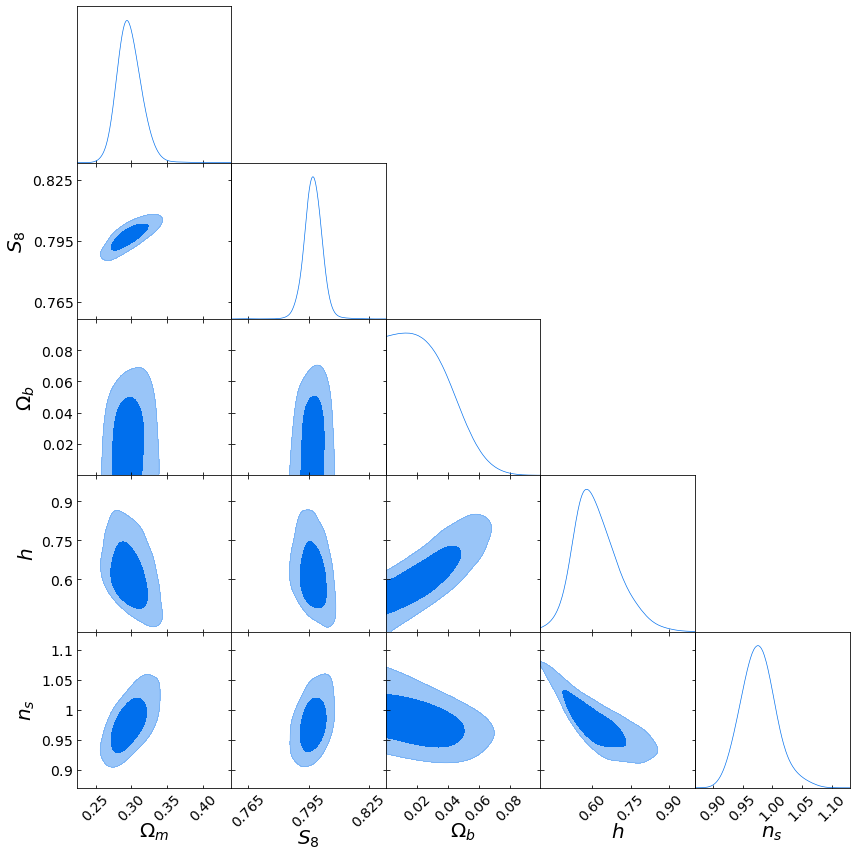

Removed no burn in


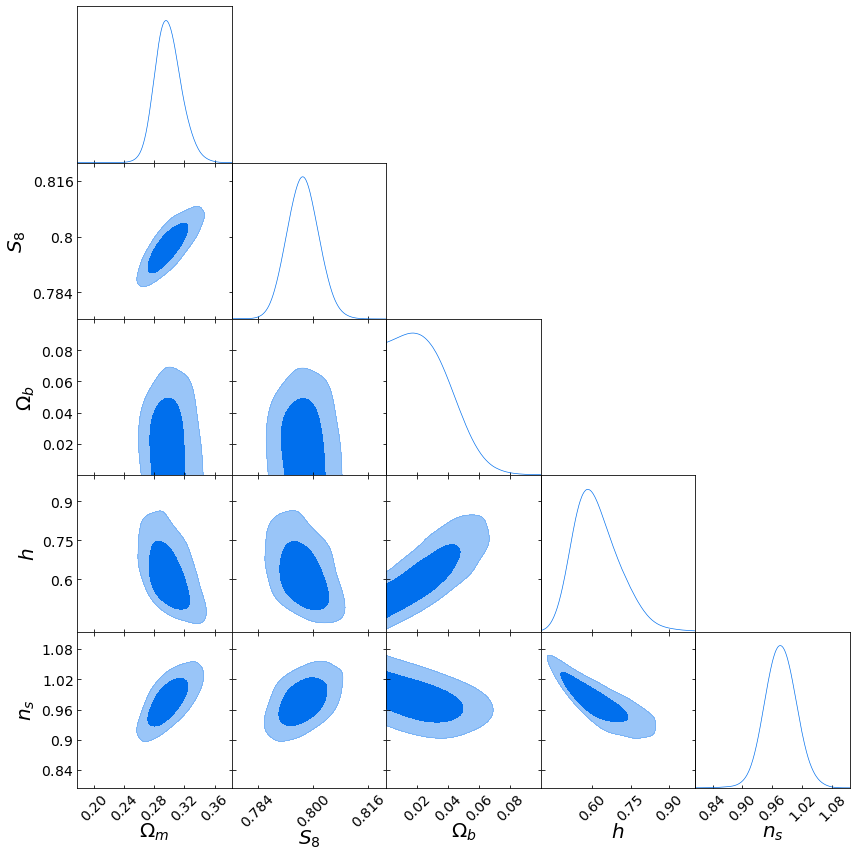

Removed no burn in


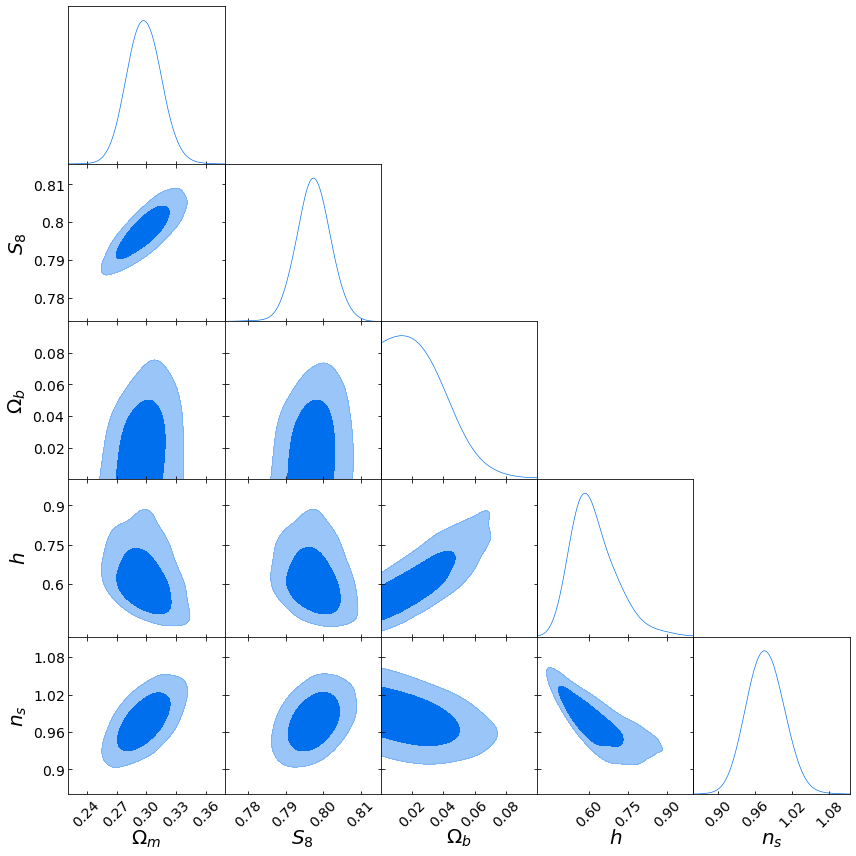

Removed no burn in


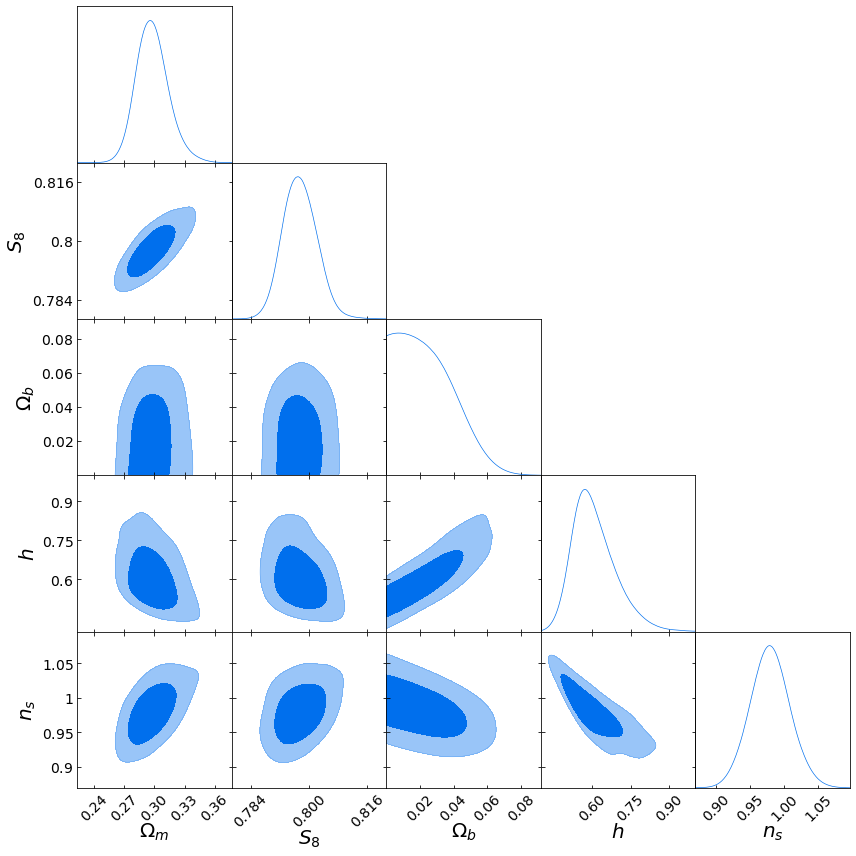

In [15]:
for i in range(6):
    DelfiEnsemble.triangle_plot(samples=samples[i:i+1])